<h1>PESGB AI conference</h1>
<h3>Feature Engineering</h3>
<p>The notebook below takes the raw Petrel export adn creates training, test and validation sets for training models in the next stage of the model pipeline and develpment</p>
<br>
<p>The raw data consists of the following feature</p>
<ol>
    <li style="color:red;">X</li>
    <li style="color:red;">Y</li>
    <li>Z</li>
    <li>TWT picked</li>
    <li>TWT auto</li>
    <li>Geological age</li>
    <li>MD</li>
    <li style="color:red;">Type</li>
    <li style="color:red;">Type</li>
    <li>Surface</li>
    <li>Well</li>
    <li style="color:red;">Interpreter</li>
    <li>Dip azimuth</li>
    <li>Missing</li>
    <li>TVT</li>
    <li>TST</li>
    <li>TVT zone</li>
    <li>TST zone</li>
    <li>Observation number</li>
    <li style="color:red;">Used by dep.conv.</li>
    <li style="color:red;">Used by geo mod</li>
    <li>Zone log</li>
    <li style="color:red;">Edited by user</li>
    <li style="color:red;">Symbol</li>
    <li style="color:red;">ULocked to fault</li>
    <li>FLOAT,GR_min_Ichron</li>
    <li>FLOAT,GR_max_Ichron</li>
</ol>
<br>
</p>Feature names in red will be remove as they were defined as adding little information to the model. The remaining feautures will be evaluated through the notebook below. YOu will notice several of the remaining feautres contain a high proportion of null values. The fraction of null values will detemin which columns are kept.</p>

<h5>Import dependancies</h5>
<ul>
    <li>pandas: feature extrapolation and extraction and creation</li>
    <li>numpy: numerical data manipluation</li>
    <li>os: interaction with the operating system</li>
    <li>seaborn: plotting library</li>
    <li>sklearn.model_selection.train_test_split: spliting the data into the various data sets (train, test and validation)</li>
</ul>

In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
from sklearn.model_selection import train_test_split

<p>set key variables for the columns we know we dont kneed the target feature and the wells we want to include int he test set</p>

In [2]:
DROP_COLUMNS = ["Well",
                "Type",
                "Zone log",
                "MD",
                "Interpreter",
                "Used by dep.conv.",
                "Used by geo mod", 
                "Edited by user",
                "Symbol",
                "Locked to fault"]

TARGET_FEATURE = "Z"

WELL_TEST = ["22/9-4", "23/21a-8","23/21-5","22/15-3","23/21-6","22/10b-6","22/10a-4", "23/11-2","22/14b-6X","22/14b-6U",
             "23/6-1","22/14b-6W","22/14b-9", "22/14b-6V","22/14b-6S", "22/15-4", "22/14b-6T","22/14b-9Z","22/14b-6Q",
             "23/16b-9","23/16f-11","22/14b-8","23/21-7Z","22/14b-6Y","22/19b-4","23/16f-12","23/21-7","22/13b-7Z","23/21-1"]

<p>set up the notebook so that pandas shows the whole dataset</p>

In [3]:
pd.set_option("display.max_rows", 600)
pd.set_option("display.max_columns", 600)

</h2>Read in raw data</h2>

<p>The raw file onsists of 34 lines which contain the header information. The first 5 lines however are not, as you can see these lines document information abuot the export. then next 27 lines contain the header names followed by a final line telling again documneting the end of the columns name (i.e END HEADER)</p>

<p>FIrst read the file extracting the 27 lines which tell us the column names of the remaining file. These lines end with a new line character ("/n") so we use list comprehenssion to remove this leaving us with just the column name as a string</p>

In [4]:
headers = [i.strip() for i in open("../Well_Tops").readlines()[5:33]]

<p>Now read the file. Make sure to skip the first 34 lines for the reasons documented above and set the column names to the headers variable above.</p>

In [5]:
df = pd.read_csv("../Well_Tops", delim_whitespace=True, skiprows =34, names=headers)

<p>Pandas dosn't recognise petrels null values (-999.00) as representing a null value. The next cell takes the default petrel null values and replaces it the numpys numeric null values which pandas now knows how to handle</p>

In [6]:
df.replace(to_replace=-999.00, value = np.nan, inplace=True)

In [7]:
df = df.loc[df.Surface != "TD"]

<p>convert depth values to positive number</p>

In [8]:
df.Z = df.Z * -1
df["TWT auto"] = df["TWT auto"] * -1 

<p>IN the cell below we look to see what fraction of the data in each column is null. If there is greated than 60% (0.6) of data in a column which is null we drop the column</p>

In [9]:
for i in df.columns:
    frac_null = df[i].isna().sum() /len(df)  
    if frac_null > 0.6:
        df.drop(columns=i, inplace=True)

In [10]:
wells = df["Well"]

<p>Now we drop the aditional columns which we identified above as not providing valuable inforation with regards to the values we're trying to predict</p>

In [11]:
df_global = df.loc[df.Well.isin(WELL_TEST)]
df_global_train = df.loc[~df.Well.isin(WELL_TEST)]

In [12]:
df.drop(columns=DROP_COLUMNS, inplace=True)

<p>Using seaborns pairplot function we can view all the remaining feature to make sure we have data and the relationships look sensible</p>

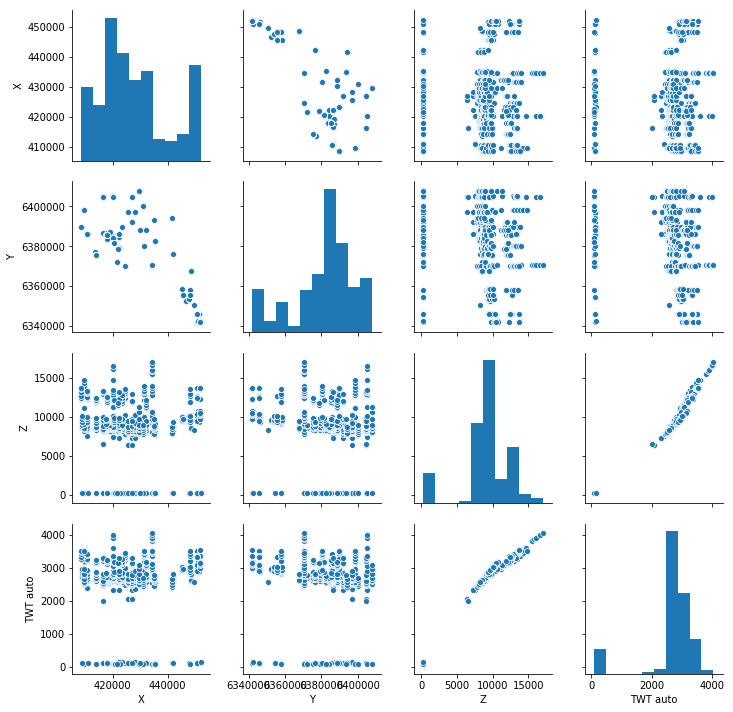

In [13]:
sns.pairplot(df)

<p>The ML models we're going to use only take in numerical inputs so we must first convert all categorical data to dummy variables. This proceess piviots the data such that each item in categorical column becomes a new column with a 0 if that catogory isn't true or a 1 if it is true</p>

In [14]:
df_train = pd.get_dummies(data=df, columns=["Surface"], drop_first =True)

<p>Check to see if we have a suitable place to store the data. If we dont lets set up a suitable place in the directory to output the data</p>

In [15]:
folder_create = os.path.exists("data")
if folder_create is False:
    os.mkdir("./data")
    os.mkdir("./data/train")
    os.mkdir("./data/test")

In [16]:
df_train["Wells"] = wells

In [17]:
train_feat = list(df_train)
train_feat.remove(TARGET_FEATURE)

<p>use the above variable to then create dataframces for the dependant (what we want to predict) and independat varaible (features)</p>

In [18]:
df_train_feat = df_train.loc[:,train_feat]
df_train_target = df_train.loc[: , [TARGET_FEATURE, "Wells"]]

<p>This data then gets split into train and validation sets. Training set is what we use to train the model and the validation set is what we can use to optimise the model parametres</p>

In [19]:
X_train = df_train_feat.loc[~df_train_feat.Wells.isin(WELL_TEST)]
X_test = df_train_feat.loc[df_train_feat.Wells.isin(WELL_TEST)]

y_train = df_train_target.loc[~df_train_target.Wells.isin(WELL_TEST)]
y_test = df_train_target.loc[df_train_target.Wells.isin(WELL_TEST)]

<p>finaly output the data to the created local directories</p>

In [20]:
X_train.drop(columns="Wells", inplace=True)
X_test.drop(columns="Wells", inplace=True)
y_train.drop(columns="Wells", inplace=True)
y_test.drop(columns="Wells", inplace=True)

C:\Users\DR25798\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [26]:
X_train.to_csv("./data/train/train_x.csv", index_label=False, index=False)
y_train.to_csv("./data/train/train_y.csv", index_label=False, index=False)
X_test.to_csv("./data/test/test_x.csv", index_label=False, index=False)
y_test.to_csv("./data/test/test_y.csv", index_label=False, index=False)

In [28]:
df_global_train.to_csv("global_train_df.csv", index_label=False, index=False)
df_global.to_csv("global_test_df.csv", index_label=False, index=False)